# Configuring the Solver with Bandits

In this tutorial, we are interested in optimizing the "branching/scorefac" parameters of SCIP, which controls the way Strong Branching scores are computed when using the sum score function ("branching/scorefunc = s"). This parameter has a value of 0.167 in SCIP default.

https://www.scipopt.org/doc/html/PARAMETERS.php

## Setting up the environment

We set up SCIP to use the sum score function, the "vanillafullstrong" branching rule to mitigate the impact of branching heuristics, and we deactivate presolving to save running time in this tutorial.

We formulate this parameter tuning task as a pure bandit problem, which we instanciate using a `ecole.environment.Configuring` environment without no observation, and the number of nodes as the metric of interest to be minimized.

In [5]:
import ecole as ec

env = ec.environment.Configuring(
    scip_params={
        "branching/scorefunc": 's',  # sum score function
        "branching/vanillafullstrong/priority": 666666,  # use vanillafullstrong (highest priority)
        "presolving/maxrounds": 0,  # deactivate presolving
#         "misc/catchctrlc": False,
    },
    observation_function=None,  # pure bandit, no observation
    reward_function=-ec.reward.NNodes(),  # minimize the total number of nodes
)

## Setting up the MILP distribution

We consider randomly generated Combinatorial Auction problems as the MILP distribution for which we want to optimize SCIP. We set up a generator of small sized instances for the purpose of this tutorial.

In [6]:
from utilities import InstanceGenerator, generate_cauctions

# new instances will be generated on-the-fly
instances = InstanceGenerator(generate_cauctions, n_items=100, n_bids=100, add_item_prob=0.7)

## Bandit optimization

We can now readily solve the optimization problem using an adequate library, such as `scikit-optimize`.

In [23]:
import sklearn
import skopt

# filter out irrelevant skopt warnings 
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

# make the sampling process determinist
seed = 42
env.seed(seed)
instances.seed(seed)

def noisy_function_to_optimize(x):

    # pick up a new random instance to set up the episode initial state
    with next(instances) as instance_file:
        env.reset(instance_file.name)

    # apply the action and collect the reward
    _, _, reward, _, _ = env.step({"branching/scorefac": x[0]})

    return -reward  # minimization (thus negated reward)

# set up the optimizer
opt = skopt.Optimizer(dimensions=[(0.0, 1.0)], base_estimator="GP", n_initial_points=50, acq_func="PI")

# actual optimization
result = opt.run(noisy_function_to_optimize, n_iter=500)

print(f"best parameter value: branching/scorefac = {result.x[0]}")

best parameter value: branching/scorefac = 0.07981015615638067


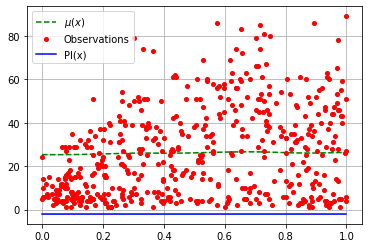

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from skopt.acquisition import gaussian_pi

def plot_optimizer(opt, x):
    model = opt.models[-1]
    x_model = opt.space.transform(x.tolist())

    # Plot Model(x) + contours
    y_pred, sigma = model.predict(x_model, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(opt.Xi, opt.yi,
             "r.", markersize=8, label="Observations")

    acq = gaussian_pi(x_model, model, y_opt=np.min(opt.yi))
    # shift down to make a better plot
    acq = 4 * acq - 2
    plt.plot(x, acq, "b", label="PI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')

    # Adjust plot layout
    plt.grid()
    plt.legend(loc='best')

plot_optimizer(opt, np.linspace(0, 1, 50).reshape(-1, 1))